#Support Vector Machines
##Overview
This notebook runs a number of support vector machine (SVM) models on our dataset. The SVM is a *supervised* model that constructs a *decision boundary* between classes. To understand how an SVM works, we can consider the simple case of binary classification using two features. An example would be classifying fruits as apples or oranges (two classes) based on size and color (two features). Then, a linear SVM constructs a line (i.e., a 2-dimensional hyperplane) that separates apples from oranges. Each input vector (an apple or an orange) is then classified depending on what side of the line it sits on. The figure below visually demonstrates this process.

<img src="SVM_image_1.png" width=200 height=133/>

The above image perfectly classifies each input; all the orange inputs are on the orange side of the decision line, and all the blue lines are on the blue side. In practice, we will not usually be able to construct a perfect line (nor would we want to -- this would usually be a sign of overfitting). To determine the optimal decision boundary, the margin between the decision boundary and the closest datapoints is maximized subject to some constraint. This amounts to maximizing the distance between the dashed line and the solid line in the above image; the logic of maximizing this distance is that, the larger the distance, the more confident we are that the points closest to the hyperplane are placed in the correct class. A possible result is the below image, which misclassifies some datapoints: 

<img src="SVM_image_2.png" width=200 height=133/>

The optimization is constrained by a parameter $C$, which essentially represents the number of points that are allowed to be misclassified. To determine the optimal $C$, we use cross-validation, which tests multiple values of $C$ and measures their accuracy using k-fold cross-validation (i.e., splitting the training set into k subsets, and then running the model k times, each time with a different subset acting as the validation set). The model (i.e., parameter) that performs best is then returned, and this becomes the model we use.

For this project, features are words, so we have thousands of features. As input to the SVM functions below, we use a matrix of size num_cases\*num_words_in_vocab, and a vector of length num_cases, which has the issue area of each case. We try both linear and non-linear SVMs on various combinations of words.

Source (for all images and for explanation of SVMs above): https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

##TF-IDF term weighting 
TF-IDF (term-frequency inverse document-frequency) is a method for extracting the usefulness of words and terms for classification. TF-IDF weighting increases the weight on words that appear many times in a document, as these words are likely more relevant to the document's classification. However, it also weights down for the number of documents a term appears in, since a term that appears in many documents is unlikely to be good at *distinguishing* between topic areas. The TF-IDF matrix also normalizes to 1 the length of each row. This mean, for example, that if we compare the sentence "The dog ran" with the (ungrammatical) sentence "The dog ran the dog ran," the two sentences would have the same normalized row vector. Without normalization, the latter sentence would be twice the length of the former.

The formula for the (non-normalized) TF-IDF frequency of a given word in a given document is:  

$$\boxed{\text{TF-IDF frequency} = tf * (idf + 1)}$$

$$tf = \frac{\text{number of times word appears in document}}{\text{total number of words in document}}$$

$$idf = \frac{\text{total number of documents}}{\text{number of documents in which word appears}}$$

To implement TF-IDF weighting, we follow the sklearn documentation: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting, http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

The below function takes training and test bag-of-words matrices (size n_documents_training\*vocab_size, n_documents_test\*vocab_size), and outputs the corresponding tfidf matrix. We show an example below. 

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
#this function takes a training matrix of size n_documents_training*vocab_size and a test matrix
#of size n_documents_test*vocab_size. The function outputs the corresponding tfidf matrices.
#Note that we fit on the training data, and then apply that fit to the test data.
def tfidf_mat_creator(trainmatrix,testmatrix):
    tf_idf_transformer=TfidfTransformer()
    tfidf_fit = tf_idf_transformer.fit(trainmatrix)
    tfidf_train = tfidf_fit.transform(trainmatrix).toarray()
    tfidf_test = tfidf_fit.transform(testmatrix).toarray()
    return(tfidf_train,tfidf_test)

In [4]:
#Example TF-IDF matrix
samplematrix = np.random.randint(0, high=5, size=(3,4))
print "Sample bag-of-words matrix of 3 documents, vocab size 4 words: "
print samplematrix
print "tfidf transformation of above matrix: " 
print TfidfTransformer().fit_transform(samplematrix).toarray()

Sample bag-of-words matrix of 3 documents, vocab size 4 words: 
[[1 4 1 2]
 [3 0 2 0]
 [0 3 3 0]]
tfidf transformation of above matrix: 
[[ 0.20195334  0.80781337  0.15683479  0.53108875]
 [ 0.88804191  0.          0.45976251  0.        ]
 [ 0.          0.78980693  0.61335554  0.        ]]


##Running SVMs

To begin, we create a dictionary that will keep track of the accuracy scores of each model that we test. This will allow us to easily determine which is the best SVM model at the end of this notebook. 

In [5]:
SVM_resultsdict = {}

#entries to this dictionary will be of the form: 
# key = model_name (model_name is a string, such as "noun_linear_svm")
# value = (model, accuracy_score). model is a fit sklearn model instance, and accuracy_score is the 
# accuracy of the model in the (0,1) range.

###Training multiple SVMs on nouns
We initially try running SVMs with only nouns, since nouns have the largest vocabulary and seem the most likely to distinguish topics. (Later, we will consider other types of words as well.) Also, please note that we loosely followed the following site for constructing SVMs (though we run many more SVM models than it does): https://www.quantstart.com/articles/Supervised-Learning-for-Document-Classification-with-Scikit-Learn.

To begin, we import the nouns data in the following cell.

In [6]:
%%time
#GET TRAINING AND TEST MATRICES FOR NOUNS
noun_train_df = pd.read_csv('noun_train_mat.csv',sep=',',header=None)
noun_train_mat = noun_train_df.values
noun_test_df = pd.read_csv('noun_test_mat.csv',sep=',',header=None)
noun_test_mat = noun_test_df.values
train_issue_areas_df = pd.read_csv('train_issue_areas.csv',sep=',',header=None)
train_issue_areas = train_issue_areas_df.values.ravel()
test_issue_areas_df = pd.read_csv('test_issue_areas.csv',sep=',',header=None)
test_issue_areas = test_issue_areas_df.values.ravel()

CPU times: user 12.7 s, sys: 702 ms, total: 13.4 s
Wall time: 19 s


We write functions cv_optimize and do_classify. These functions allow us to run SVMs with a variety of parameters, and enable cross-validation to further optimize the SVMs. The functions are similar to the equivalently named functions in problem set 3 (and the code for these functions is modified from the code in problem set 3). We also write a function to create a confusion matrix, as the sklearn confusion_matrix function was not working well. 

In [7]:
"""
Function
--------
confusion_mat_creator

Inputs
------
predictions: a list of length n_documents. Each value in the list is the predicted
             issue area of the corresponding document. ("Predicted" as predicted by the SVM.)
actuals: a list of length n_documents. Each value is the actual issue area of the corresponding document.

Returns
-------
A 14*14 confusion matrix. Cell i,j is the number of cases with actual issue area j 
that were predicted as issue area i. Thus, the diagonal represents correct predictions.

Notes
-----
see do_classify below for an example of how this is used
"""

def confusion_mat_creator(predictions,actuals): 
    confusion_mat = np.zeros((14,14))
    for i in range(len(predictions)):
        #get predicted and actual issue ares; subtract by 1 since matrix is 0-indexed
        p_val = predictions[i]-1
        a_val = actuals[i]-1
        confusion_mat[p_val,a_val]+=1 #Matrix is thus predicted values*actual values 
    return(confusion_mat)

In [8]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV
X: a document-word matrix (e.g., noun_train_tfidf). Should be training data.
y: the response vector (train_issue_areas)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
Two things: (1) The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model; and (2) the best parameter. 
     
Notes
-----
see do_classify below for an example of how this is used
"""
from sklearn.grid_search import GridSearchCV
#note: this code comes directly from lab 6
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    best_estimator = gs.best_estimator_
    best_param = gs.best_params_
    return (best_estimator,best_param)

In [13]:
"""
Function
--------
do_classify

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV
Xtrain: a training matrix document-word matrix (e.g., noun_train_tfidf)
ytrain: the corresponding training response vector (train_issue_areas)
Xtest: a test matrix document-word matrix (e.g., noun_test_tfidf)
ytest: the corresponding test resonse vector (e.g., noun)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
4 things, in the following order: (1) an array of predicted y values (ie, topic areas) for the test data; 
                                  (2) the accuracy score; (3) the confusion matrix of the test data predictions;
                                  (4) the best parameter from the gridsearch.

"""

##from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, Xtrain, ytrain, Xtest, ytest, score_func=None, n_folds=4):
    if parameters:
        clf,best_param = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "Best parameter: ", best_param
    pred = clf.predict(Xtest)
    print "########################################################"
    print confusion_mat_creator(pred, ytest)
    return(pred,test_accuracy,confusion_mat_creator(pred,ytest),best_param,clf)

We convert the noun matrices to TF-IDF matrices.

In [14]:
noun_train_tfidf,noun_test_tfidf = tfidf_mat_creator(noun_train_df,noun_test_df)

####Linear SVMs
We optimize linear SVMs on nouns across six parameter values.

In [15]:
%%time
from sklearn.svm import LinearSVC
#Try do_classify on best 6 parameters
parameters1 = {"C": [0.0001, 0.01, 1.0, 100.0, 1000.0, 100000.0]}
predictions1,accuracy1,confusion_matrix1,best_param1,clf1=do_classify(LinearSVC(loss='hinge'), parameters1, 
                                                                 noun_train_tfidf,train_issue_areas,
                                                                 noun_test_tfidf,test_issue_areas)

############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.68
Best parameter:  {'C': 1.0}
########################################################
[[ 91.  15.   6.   4.   1.   1.   0.   5.   7.   0.   0.   0.   1.   0.]
 [  4.  64.   4.   3.   0.   0.   0.   4.   6.   2.   0.   1.   0.   0.]
 [  1.   2.  21.   0.   0.   0.   0.   3.   1.   0.   0.   0.   0.   0.]
 [  1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   1.   0.   0.  22.   1.   3.   6.   0.   0.   0.   0.]
 [  5.   6.   2.   3.   2.   1.   3.  89.  14.   9.   0.   7.   0.   0.]
 [  2.  10.   4.   3.   0.   1.   1.   2.  37.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   0.   

In the next cell, we further optimize the linear SVM based on the optimal parameter above. This means re-optimizing over a smaller range of parameters. 

In [16]:
#Rerun do_classify based on the best parameter above
paramvalue = best_param1.values()[0]
parameters2 = {"C": [paramvalue/10.,paramvalue,paramvalue*10]}
predictions2,accuracy2,confusion_matrix2,best_param2,clf2=do_classify(LinearSVC(loss='hinge'), parameters2, 
                                                             noun_train_tfidf,train_issue_areas,
                                                             noun_test_tfidf,test_issue_areas)

############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.68
Best parameter:  {'C': 1.0}
########################################################
[[ 91.  15.   6.   4.   1.   1.   0.   5.   7.   0.   0.   0.   1.   0.]
 [  4.  64.   4.   3.   0.   0.   0.   4.   6.   2.   0.   1.   0.   0.]
 [  1.   2.  21.   0.   0.   0.   0.   3.   1.   0.   0.   0.   0.   0.]
 [  1.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   1.   0.   0.  22.   1.   3.   6.   0.   0.   0.   0.]
 [  5.   6.   2.   3.   2.   1.   3.  89.  14.   9.   0.   7.   0.   0.]
 [  2.  10.   4.   3.   0.   1.   1.   2.  37.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   0.   

The best SVM is the one with parameter C=1.0. We save this SVM in our dictionary of best SVMs.

In [17]:
SVM_resultsdict['linear_nouns'] = (clf2,accuracy2)

####Non-linear SVCs

The next cell optimizes a kernelized SVM across a 5\*4 array of parameters. Because it takes a long time to run on 20 parameters, we only run it once. (We've included an image of the initial output below, as we lost that output when we ran the commented out cell by accident.) 

In [19]:
from sklearn.svm import SVC
##%%time
#parameters grid
##parameters3 = {"C": [1e-5,1e-3,1,1e3,1e5],"gamma":[0,1e-3,1e-5,1e-7]}
#test non-linear (kernelized) SVMs
##predictions3,accuracy3,confusion_matrix3,best_param3,clf3=do_classify(SVC(), parameters3, 
##                                                             noun_train_tfidf,train_issue_areas,
##                                                             noun_test_tfidf,test_issue_areas)

<img src="kernelized_svm_output.png" width=600 height=400/>

We further optimize a kernelized SVM based on the best parameters from the above cell. The result shows that in fact, the best parameters were the ones in the above cell ($C=1e^5$, gamma=$1e^{-5}$). We save this model in our dictionary. (We have commented out the below cell to avoid rerunning it by accident, since it takes so long!)

In [20]:
'''
%%time
#parameters grid
parameters4 = {"C": [1e4,1e5,1e6],"gamma":[1e-4,1e-5,1e-6]}
#test non-linear (kernelized) SVMs
predictions4,accuracy4,confusion_matrix4,best_param4,clf4=do_classify(SVC(), parameters4,
                                                                 noun_train_tfidf,train_issue_areas,
                                                                 noun_test_tfidf,test_issue_areas)
'''

############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.68
Best parameter:  {'C': 1000000.0, 'gamma': 1e-06}
########################################################
[[ 89.  12.   3.   3.   1.   2.   0.   3.   6.   0.   0.   0.   1.   0.]
 [  6.  65.   8.   5.   1.   0.   0.   4.   7.   2.   0.   1.   0.   0.]
 [  0.   2.  21.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.]
 [  2.   1.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  22.   1.   2.   5.   0.   0.   0.   0.]
 [  4.   6.   1.   5.   1.   1.   3.  87.  14.   8.   1.   7.   0.   0.]
 [  3.  10.   5.   0.   0.   0.   1.   6.  38.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   2.   0.   9.   3.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 

In [21]:
SVM_resultsdict['kernelized_nouns'] = (clf4,accuracy4)

###SVMs on other types of words
So far, we have only tried running SVMs on nouns. We got equally good output (accuracy score = .68) for both the linear SVM and the kernelized SVM, using their respective optimized parameters. However, we may be able to get better ouput by running the SVM on other types of words (eg, verbs, precedents, etc.), or by running it on multiple types of words (e.g., nouns and precedents together).

Note that we only train linear SVMs for the remainder of this notebook. This is because, in the nouns section above, the linear and nonlinear SVMs returned the same accuracy, but the non-linear SVM takes *much* longer to run.

In [22]:
%%time
#first, we import the different types of words 
prec_train_df = pd.read_csv('prec_train_mat.csv',sep=',',header=None)
prec_train_mat = prec_train_df.values
prec_test_df = pd.read_csv('prec_test_mat.csv',sep=',',header=None)
prec_test_mat = prec_test_df.values

verb_train_df = pd.read_csv('verb_train_mat.csv',sep=',',header=None)
verb_train_mat = verb_train_df.values
verb_test_df = pd.read_csv('verb_test_mat.csv',sep=',',header=None)
verb_test_mat = verb_test_df.values

adj_train_df = pd.read_csv('adj_train_mat.csv',sep=',',header=None)
adj_train_mat = adj_train_df.values
adj_test_df = pd.read_csv('adj_test_mat.csv',sep=',',header=None)
adj_test_mat = adj_test_df.values

for_train_df = pd.read_csv('for_train_mat.csv',sep=',',header=None)
for_train_mat = for_train_df.values
for_test_df = pd.read_csv('for_test_mat.csv',sep=',',header=None)
for_test_mat = for_test_df.values

CPU times: user 8.05 s, sys: 664 ms, total: 8.71 s
Wall time: 16.5 s


We define a function `matrix_combine`, which takes a list of matrix tuples as inputs. Each tuple has two elements, which must be the training and test matrices of the same word type. For example, an input could be: `[(for_train_mat,for_test_mat),(adj_train_mat,adj_test_mat)]`. The function outputs the concatenated test and training matrices. 

In [27]:
def matrix_combine(matrix_list):    
    train_mat = np.concatenate(([element[0] for element in matrix_list]),axis=1)
    test_mat = np.concatenate(([element[1] for element in matrix_list]),axis=1)
    return(train_mat,test_mat)

#### Verbs, adjectives, precedents, foreign
We try running the linear SVM on each of the four types of words, similar to what we did with nouns earlier. We put all of these SVMs in our results dictionary so that we can compare the different word types at the end.

In [28]:
#loop through each type of words 
for matrixpair in [(prec_train_mat,prec_test_mat,'prec'),(adj_train_mat,adj_test_mat,'adj'),
                   (verb_train_mat,verb_test_mat,'verb'),(for_train_mat,for_test_mat,'for')]:
    #convert to TF-IDF form 
    train_tfidf1,test_tfidf1 = tfidf_mat_creator(matrixpair[0],matrixpair[1])
    #run do-classify
    predictions,accuracy,confusion_matrix,best_param,clfoutput=do_classify(LinearSVC(loss='hinge'), {'C':[1.0]},
                                                                 train_tfidf1,train_issue_areas,
                                                                 test_tfidf1,test_issue_areas)
    #save results  
    SVM_resultsdict[matrixpair[2]]=(clfoutput,accuracy)

############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.29
Best parameter:  {'C': 1.0}
########################################################
[[ 95.  73.  22.   9.   2.   6.  15.  81.  52.  16.   4.  15.   1.   0.]
 [  3.  10.   0.   1.   0.   0.   0.   1.   3.   2.   0.   0.   0.   0.]
 [  0.   1.  12.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  1.   0.   1.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.   0.   0.   0.]
 [  4.   9.   2.   1.   0.   0.   5.  13.   6.   3.   0.   2.   0.   0.]
 [  1.   3.   1.   1.   1.   0.   0.   4.   6.   1.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   3.   1.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   

We compare the accuracy of each word type considered so far. We see that the linear SVM on nouns performs the best. 

In [29]:
for key,value in SVM_resultsdict.iteritems(): 
    print key, ': ', value[1]

for :  0.169291338583
linear_nouns :  0.681102362205
prec :  0.28937007874
kernelized_nouns :  0.679133858268
verb :  0.478346456693
adj :  0.411417322835


####Combinations of word types
Verbs and adjectives give decent results, and precedents is not terrible. Let's try combining each of these with nouns and seeing what the results are.

In [30]:
%%time
#EACH OF VERBS, PRECEDENTS, ADJ COMBINED WITH NOUNS 
nouncomboslist = [[(verb_train_mat,verb_test_mat),(noun_train_mat,noun_test_mat),'verbs-nouns'],
                  [(prec_train_mat,prec_test_mat),(noun_train_mat,noun_test_mat),'prec-nouns'],
                  [(adj_train_mat,adj_test_mat),(noun_train_mat,noun_test_mat),'adj-nouns']]
combosdict={}
for combo in nouncomboslist: 
    #concatenate the nouns matrix and the other matrix 
    train_combo,test_combo = matrix_combine([combo[0],combo[1]])
    #convert to tfidf 
    train_tfidf,test_tfidf = tfidf_mat_creator(train_combo,test_combo)
    #do_classify 
    predictions,accuracy,confusion_matrix,best_param,clfoutput=do_classify(LinearSVC(loss='hinge'), {'C':[1.0]},
                                                                           train_tfidf,train_issue_areas,test_tfidf,
                                                                           test_issue_areas)
    #get accuracies in dict 
    combosdict[combo[2]] = (clfoutput,accuracy) 

############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.69
Best parameter:  {'C': 1.0}
########################################################
[[ 92.  15.   6.   4.   1.   1.   0.   4.   8.   0.   0.   0.   1.   0.]
 [  1.  66.   4.   3.   0.   0.   0.   5.   6.   2.   1.   1.   0.   0.]
 [  0.   2.  22.   0.   0.   0.   0.   3.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.  23.   1.   2.   6.   0.   0.   0.   0.]
 [  6.   5.   3.   3.   1.   1.   2.  88.  16.   9.   0.   6.   0.   0.]
 [  5.   9.   3.   1.   1.   1.   1.   3.  35.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   

We compare the output of each word type. Because they all have good accuracy scores, we put them in SVM_resultsdict.

In [31]:
for key,value in combosdict.iteritems():
    print key, ': ', value[1]
    SVM_resultsdict[key]=value

verbs-nouns :  0.688976377953
adj-nouns :  0.681102362205
prec-nouns :  0.677165354331


As a final test, we train an SVM on verbs, nouns, precedents, and adjectives all together. It gives similar output to our other SVMs.

In [32]:
%%time
#VERBS, NOUNS, PRECEDENTS,ADJECTIVES COMBINED 
vnpatuples = [(verb_train_mat,verb_test_mat),(noun_train_mat,noun_test_mat),
              (prec_train_mat,prec_test_mat),(adj_train_mat,adj_test_mat)]
#concatenate 
vnpa_train,vnpa_test = matrix_combine(vnpatuples)
#convert to TFIDF
vnpa_train_tfidf, vnpa_test_tfidf = tfidf_mat_creator(vnpa_train,vnpa_test)
#run do_classify
predictions_vnpa,accuracy_vnpa,confusion_matrix_vnpa,best_param_vnpa,clfoutput_vnpa=do_classify(LinearSVC(loss='hinge'),
                                                                                                {'C':[1.0]},vnpa_train_tfidf,
                                                                                                train_issue_areas,vnpa_test_tfidf,
                                                                                                test_issue_areas)

############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.68
Best parameter:  {'C': 1.0}
########################################################
[[ 91.  16.   5.   5.   1.   1.   0.   4.   9.   0.   0.   0.   1.   0.]
 [  3.  66.   4.   3.   0.   0.   0.   4.   5.   2.   1.   1.   0.   0.]
 [  0.   2.  22.   0.   0.   0.   0.   3.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.  22.   1.   2.   7.   0.   0.   0.   0.]
 [  5.   5.   3.   3.   1.   1.   3.  90.  19.   9.   0.   6.   0.   0.]
 [  5.   8.   4.   2.   1.   1.   1.   2.  32.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   

Accuracy of .68 is fairly good, so we append this final model to our dictionary of SVM results.

In [35]:
SVM_resultsdict['vnpa_combo'] = (clfoutput_vnpa,accuracy_vnpa)

##Evaluating SVM results 
We want to compare the results of the various SVMs in our results dictionary. This will allow us to pick a best SVM, which we will ultimately compare against the other models (naive bayes, k-means, NMF, etc.). 

To begin, we create a simple bar graph comparing the accuracy of the SVMs. We see that al of the SVMs that include nouns have similar performance, while the other SVMs have much worse performance. This means that our initial assumption that nouns would be the most useful word type for classification was correct.

[]

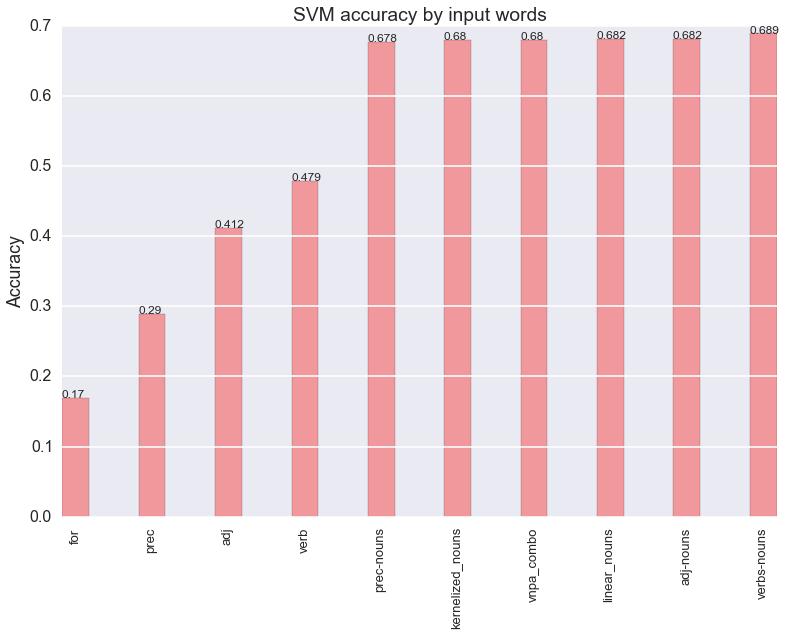

In [42]:
import math
#BAR GRAPH OF ACCURACIES 
#make lists of model names and accuracies,sorted by accuracy 
names_accuracies = [(key, value[1]) for key,value in SVM_resultsdict.iteritems()]
names_accuracies = sorted(names_accuracies,key=lambda x: x[1])
modelnames = [element[0] for element in names_accuracies]
modelaccuracies = [element[1] for element in names_accuracies]

#print bar graph of accuracies 
#(for help with bar graph creation, I referenced: http://matplotlib.org/examples/api/barchart_demo.html)
N = len(modelaccuracies)
ind = np.arange(N) #x locations of bars 
width = .35 #bar width
plt.grid(zorder=10)
plt.gca().xaxis.grid(False)
plt.bar(ind, modelaccuracies, width, color='r',alpha=.35,zorder=0)
plt.title("SVM accuracy by input words")
plt.ylabel('Accuracy')
plt.xticks(ind + width/2,modelnames,rotation=90,size=13)
#show values on top of rectangles
xloc = [location for location in ind]
yloc = [math.ceil(height*1000)/1000 for height in modelaccuracies]
for a,b in zip(xloc, yloc):
    plt.text(a, b, str(b),size=12)

plt.plot()

We are most interested in the results of our best SVM, the linear SVM that uses both verbs and nouns as input. Let's rerun this SVM.

In [41]:
%%time
#RERUN BEST SVM
vn_list = [(verb_train_mat,verb_test_mat),(noun_train_mat,noun_test_mat)]
train_vn,test_vn = matrix_combine([vn_list[0],vn_list[1]])
#convert to tfidf 
vn_train_tfidf,vn_test_tfidf = tfidf_mat_creator(train_vn,test_vn)
#do_classify 
best_predictions,best_accuracy,best_con_mat,best_param,best_clf=do_classify(LinearSVC(loss='hinge'), {'C':[1.0]},
                                                                       vn_train_tfidf,train_issue_areas,vn_test_tfidf,
                                                                       test_issue_areas)

############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.69
Best parameter:  {'C': 1.0}
########################################################
[[ 92.  15.   6.   4.   1.   1.   0.   4.   8.   0.   0.   0.   1.   0.]
 [  1.  66.   4.   3.   0.   0.   0.   5.   6.   2.   1.   1.   0.   0.]
 [  0.   2.  22.   0.   0.   0.   0.   3.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.  23.   1.   2.   6.   0.   0.   0.   0.]
 [  6.   5.   3.   3.   1.   1.   2.  88.  16.   9.   0.   6.   0.   0.]
 [  5.   9.   3.   1.   1.   1.   1.   3.  35.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   

We now check how well the best SVM performed for each issue area. Recall that the confusion matrix (printed just above) is of the form predicted by actual. For example, cell (1,0) of the above matrix means that 15 cases that are actually in issue area 1 were placed in issue area 1. (We must add 1 to the cell indices, since the matrix is zero-indexed.) We use the confusion matrix to plot a bar graph of **true positive rate by issue area**. Each bar therefore measures: 


$$ \text{true postive rate of issue area  }j = \frac{\text{number true positives in issue area  } j}{\text{number true positives + number false negatives in issue area  } j} = \frac{\text{number true positives in issue area  } j}{\text{total number cases actually in issue area  } j}$$ 

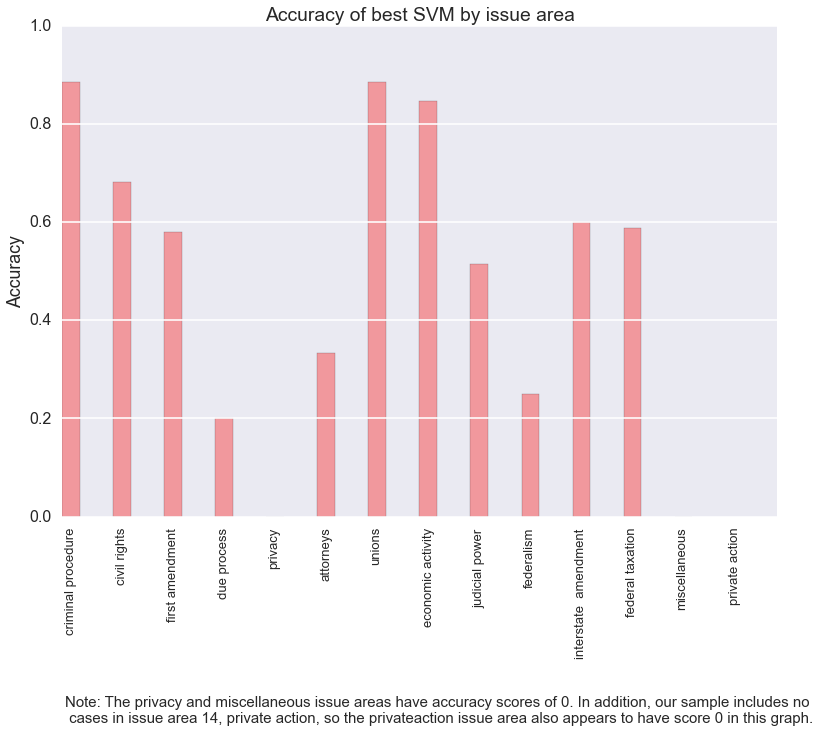

In [44]:
#BAR GRAPH OF TRUE POSITIVE RATE BY ISSUE AREA
#calculate accuracies 
i=0
accuracy_by_issue = []
for column in best_con_mat.T:
    accuracy_rate = float(column[i])/column.sum()
    accuracy_by_issue.append(accuracy_rate)
    i+=1
#issue areas
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]
#print bar graph
N = len(accuracy_by_issue)
ind = np.arange(N) #x locations of bars 
width = .35 #bar width
plt.grid(zorder=10)
plt.gca().xaxis.grid(False)
plt.bar(ind, accuracy_by_issue, width, color='r',alpha=.35,zorder=0)
plt.title("Accuracy of best SVM by issue area")
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.xticks(ind + width/2,issue_areas,rotation=90,size=13)
#note below x-axis
note = "Note: The privacy and miscellaneous issue areas have accuracy scores of 0. \
In addition, our sample includes no\n cases in issue area 14, private action, so the private\
action issue area also appears to have score 0 in this graph."
plt.text(0.05,-.42,note,size=15)

Finally, we want to examine overlap between issue areas. We normalize each column (i.e., each vector of true issue areas) to 1 so that the cells of the heat map represent *fraction* of cases in issue area $j$ classified as issue area $i$. We create a heat map, where darker cells mean there was more overlap. The results make sense: for instance, the economic activity - federal taxation cell is fairly dark, which is not surprising since these are intuitively related topics. We also see that the darker cells on the diagonal correspond to higher diagonals in the above bar graph of true-positive rate. This is because each diagonal cell represents the true-positive rate!

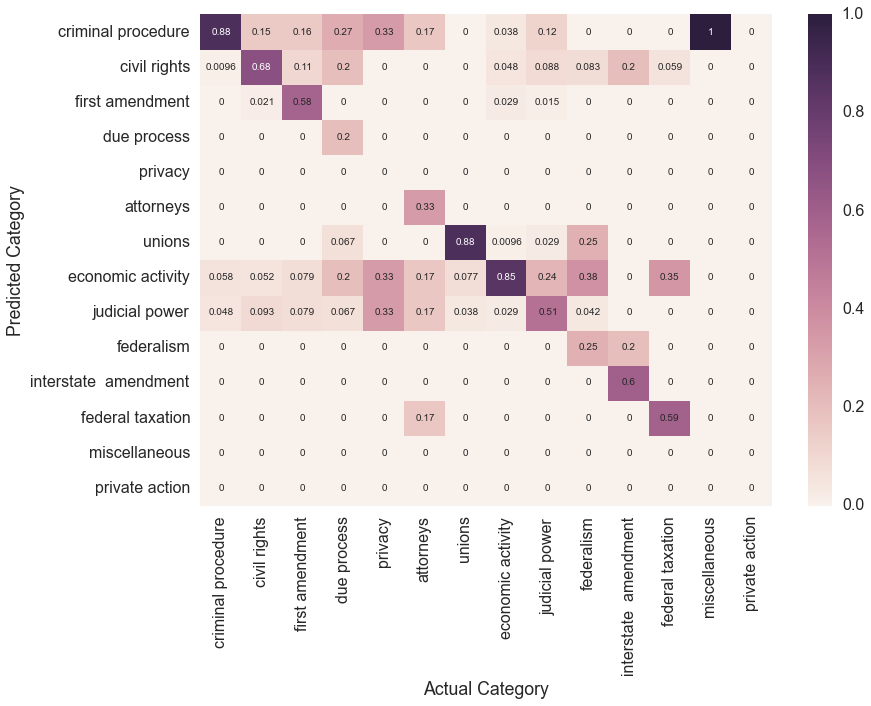

In [48]:
#HEAT MAP
best_con_mat = np.array(best_con_mat).T
best_con_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(best_con_mat))
best_con_mat = np.array(best_con_mat).T
sns.heatmap(best_con_mat, annot=True, xticklabels=issue_areas, yticklabels=issue_areas)
sns.axlabel('True (SCDB) Category', 'Predicted Category')